<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [2]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-03-14 23:02:32 INFO: Downloading default packages for language: es (Spanish)...
2022-03-14 23:02:35 INFO: File exists: /Users/ext_asalassa/stanza_resources/es/default.zip.
2022-03-14 23:02:46 INFO: Finished downloading models and saved to /Users/ext_asalassa/stanza_resources.
2022-03-14 23:02:46 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-03-14 23:02:46 INFO: Use device: cpu
2022-03-14 23:02:46 INFO: Loading: tokenize
2022-03-14 23:02:46 INFO: Loading: mwt
2022-03-14 23:02:46 INFO: Loading: pos
2022-03-14 23:02:46 INFO: Loading: lemma
2022-03-14 23:02:46 INFO: Loading: depparse
2022-03-14 23:02:47 INFO: Loading: ner
2022-03-14 23:02:50 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [4]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [5]:
text = "personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los muercielagos'

In [6]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los muercielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[muercielagos, 'muercielago']


### 3 - Diccionario de entrada

In [7]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "START",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Buen día", "Buenos días", "Buenas tardes", "Buenas noches", "Alo"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?", "Hola, ¿cómo puedo ayudarte?"],
             },
             {"tag": "GET",
              "patterns": ['¿Cuántos?', '¿Cuántos quedan?', '¿Cuánto?', '¿Cuánto queda?', '¿Cuál es el resto?', '¿Cuál resta de?', 'Resto', 'Consultar stock', 'necesitar stock', 'solicitar', 'recabar producto', 'requerir', 'querer producto', 'clamar producto', 'adquirir producto', 'querer stock', 'querer', 'necesitar', 'solicitar stock', 'exigir producto', 'exigir stock', 'adquirir', 'recabar stock', 'clamar stock', 'recabar', 'recaer stock', 'clamar', 'recibir stock', 'demandar producto', 'conjurar producto', 'conseguir stock', 'requerir stock', 'demandar', 'demandar stock', 'conjurar', 'exigir', 'captar producto', 'reclamar producto', 'conseguir producto', 'recaer producto', 'adquirir stock', 'captar', 'necesitar producto', 'conjurar stock', 'recibir', 'recibir producto', 'solicitar producto', 'conseguir', 'requerir producto', 'reclamar', 'recaer', 'captar stock', 'reclamar stock'],
              "responses": ["Esto es lo que pude obtener de la consulta"]
             },
            {"tag": "PUT",
              "patterns": ['renovar', 'reformarse producto', 'rectificarse producto', 'modificar producto', 'rectificarse', 'restablecer', 'reformar', 'modificar stock', 'cambiar stock', 'rejuvenecer stock', 'ratificar producto', 'modernizar stock', 'replantear stock', 'alterarse', 'poner al día producto', 'arreglar stock', 'alterar producto', 'alterar', 'mudar', 'alterarse stock', 'mudar producto', 'reemplazar stock', 'ratificar', 'ratificarse stock', 'actualizar stock', 'replantear producto', 'corregir stock', 'transformarse producto', 'mudarse stock', 'ratificar stock', 'reorganizar', 'restablecer stock', 'restaurar', 'restablecer producto', 'alterar stock', 'corregir', 'corregir producto', 'arreglar producto', 'renovar stock', 'transformarse stock', 'replantear', 'ratificarse', 'mudarse producto', 'cambiar producto', 'restaurar producto', 'replantearse', 'variar producto', 'reestructurar', 'rectificar stock', 'rectificar producto', 'transformar stock', 'modernizar', 'reemplazar producto', 'reestructurar producto', 'restaurar stock', 'modernizar producto', 'cambiarse producto', 'rectificarse stock', 'transformarse', 'poner al día', 'replantearse stock', 'actualizar', 'transformar', 'mudar stock', 'reorganizar producto', 'reformar stock', 'reformarse stock', 'reestructurar stock', 'ratificarse producto', 'variar stock', 'actualizar producto', 'reformarse', 'arreglar', 'cambiarse', 'mudarse', 'reformar producto', 'cambiarse stock', 'alterarse producto', 'transformar producto', 'poner al día stock', 'modificar', 'replantearse producto', 'rectificar', 'reemplazar', 'renovar producto', 'cambiar', 'reorganizar stock', 'rejuvenecer', 'variar', 'rejuvenecer producto'],
              "responses": ["Solicitud procesada! Datos actualizados"]
             },
            {"tag": "POST",
              "patterns": ["anunciar", "incorporar producto", "inlcuir elemento", "publicar", "crear", "nuevo", "dar de alta", "ingresar", "crear nuevo", "enviar", "subir", "anunciar stock", "publicar stock", "crear stock", "nuevo stock", "dar de alta stock", "ingresar stock", "crear nuevo stock", "enviar stock", "subir stock", "anunciar producto", "publicar producto", "crear producto", "nuevo producto", "dar de alta producto", "ingresar producto", "crear nuevo producto", "enviar producto", "subir producto"],
              "responses": ["Solicitud procesada! Datos nuevos en la base de datos"]
             },
            {"tag": "DELETE",
              "patterns": ['suprimir', 'anular', 'tachar', 'quitar', 'borrar', 'dar de baja', 'desaparecer', 'eliminar', 'excluir', 'arrancar', 'descartar', 'expulsar', 'omitir', 'prescindir', 'revocar', 'suprimir producto', 'anular producto', 'tachar producto', 'quitar producto', 'borrar producto', 'dar de baja producto', 'desaparecer producto', 'eliminar producto', 'excluir producto', 'arrancar producto', 'descartar producto', 'expulsar producto', 'omitir producto', 'prescindir producto', 'revocar producto', 'suprimir stock', 'anular stock', 'tachar elemento', 'quitar stock', 'borrar stock', 'dar de baja stock', 'desaparecer stock', 'eliminar stock', 'excluir stock', 'arrancar stock', 'descartar elemento', 'expulsar stock', 'omitir stock', 'prescindir stock', 'revocar stock'],
              "responses": ["Se eliminó el producto"]
             },
             {"tag": "END",
              "patterns": ["Chau", "Hasta luego!", "Muchas gracias", "Gracias", "Nos vemos"],
              "responses": ["Hasta luego! Espero haberte sido de ayuda"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [8]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords
<ipython-input-8-0458dc5bf349>:15: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(pattern.lower()))
<ipython-input-8-0458dc5bf349>:15: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['poner', 'a', 'el', 'dia', 'producto']
Entities: []

In [9]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'actualizar', 'adquirir', 'alo', 'alta', 'alterar', 'alto', 'anular', 'anunciar', 'arrancar', 'arreglar', 'baja', 'borrar', 'buen', 'cambiar', 'captar', 'chau', 'clamar', 'como', 'conjurar', 'conseguir', 'consultar', 'corregir', 'crear', 'cual', 'cuanto', 'dar', 'de', 'demandar', 'desaparecer', 'descartar', 'dia', 'el', 'elemento', 'eliminar', 'enviar', 'este', 'excluir', 'exigir', 'expulsar', 'gracias', 'hasta', 'holar', 'incorporar', 'ingresar', 'inlcuir', 'luego', 'modernizar', 'modificar', 'mucho', 'mudar', 'necesitar', 'noche', 'nuevo', 'omitir', 'poner', 'prescindir', 'producto', 'publicar', 'que', 'quedar', 'querer', 'quitar', 'ratificar', 'recabar', 'recaer', 'recibir', 'reclamar', 'rectificar', 'reemplazar', 'reestructurar', 'reformar', 'rejuvenecer', 'renovar', 'reorganizar', 'replantear', 'requerir', 'restablecer', 'restar', 'restaurar', 'resto', 'revocar', 'ser', 'solicitar', 'stock', 'subir', 'suprimir', 'tachar', 'tal', 'tarde', 'transformar', 'variar', 'ver'

In [10]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 95


In [11]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 6


In [12]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

<ipython-input-12-e332faa545aa>:10: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(doc.lower()))
<ipython-input-12-e332faa545aa>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['poner', 'a', 'el', 'dia', 'producto']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<ipython-input-12-e332faa545aa>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['poner', 'a', 'el', 'dia']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 0, 1, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<ipython-input-12-e332faa545aa>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['poner', 'a', 'el', 'dia', 'stock']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 5 - Entrenamiento del modelo

In [13]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (95,) output: 6


In [14]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
              
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12288     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 20,934
Trainable params: 20,934
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
hist = model.fit(x=train_X, y=train_y, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 3ms/step - loss: 1.7954 - accuracy: 0.2000
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 1.7043 - accuracy: 0.3304
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 1.6359 - accuracy: 0.3783
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5701 - accuracy: 0.4043
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5351 - accuracy: 0.4087
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 1.4803 - accuracy: 0.4261
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 1.4130 - accuracy: 0.3826
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 1.3881 - accuracy: 0.4348
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 1.3514 - accuracy: 0.4304
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 1.3118 - accuracy: 0.4478
Epoch 11/100
8/8 [=========

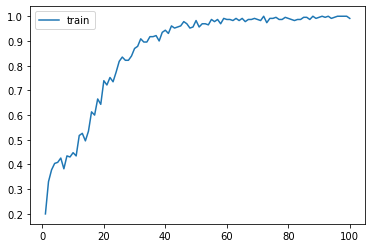

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [17]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [18]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [19]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

BOT: Hola, ¿cómo puedo ayudarte?


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords
<ipython-input-18-b69da3e56cb4>:3: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(text.lower()))
<ipython-input-18-b69da3e56cb4>:3: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['agregar', 'enebro', 'a', 'el', 'stock']
Entities: []


BOT: Solicitud procesada! Datos actualizados
BOT: Solicitud procesada! Datos nuevos en la base de datos
BOT: Solicitud procesada! Datos actualizados
Perdón, no comprendo la pregunta.
Perdón, no comprendo la pregunta.
Perdón, no comprendo la pregunta.
Perdón, no comprendo la pregunta.


KeyboardInterrupt: Interrupted by user

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words